## HW 3

For questions 1 and 2: 
- Given a dataset with time series data containing an event, use a linear regression to test whether there was a discontinuity in the data at the event. 
- Consider the possibility, first, of a discontinuity only in the value of the variable but not the derivative. -Then consider that there may be a discontinuity in the first derivative (the slope).  
- Use the file homework_3.1.csv. 

In [1]:
import pandas as pd
import numpy as np

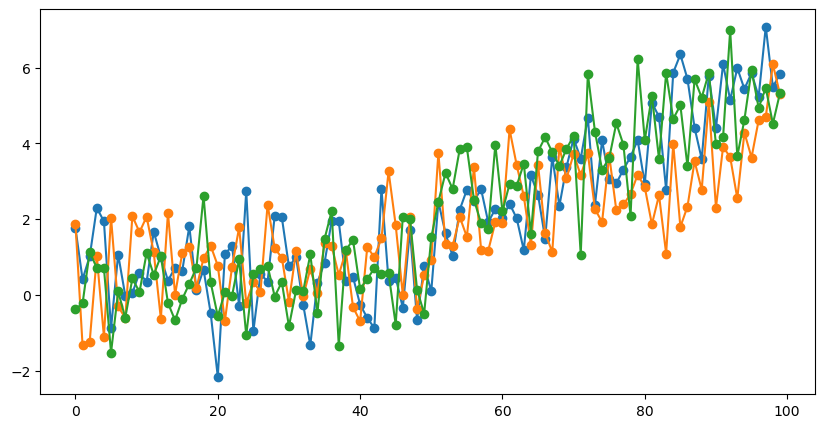

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df[['value1', 'value2', 'value3']], marker='o', linestyle='-')

Von Korpf Event Studies implementation:

In [3]:
import scipy
import seaborn as sns
import statsmodels.api as sm

t = np.arange(1000) # time variable
t0 = 500 # time of the event

# Simulating three time series with a discontinuity at t0
Y = 2 * (t < t0) + 1 * (t >= t0) + np.random.normal(0, 1, (1000,))

After = 1 * (t >= t0)
t_After = (t - t0) * After
# intercept (before), After, before trend (t), after trend (t - t0) * After

X = sm.add_constant(pd.DataFrame({"After": After, "t_After": t_After, "t": t}))
results = sm.OLS(Y, X).fit()
results.tvalues

const      21.570323
After      -8.565835
t_After     0.179413
t           0.586402
dtype: float64

In [11]:
# process question 1 dataset
df = pd.read_csv('homework_3.1.csv', index_col=0)
df.head()

,time,value1,value2,value3
0,0,1.764052,1.883151,-0.369182
1,1,0.420157,-1.327759,-0.219379
2,2,1.018738,-1.230485,1.139660
3,3,2.300893,1.029397,0.715264
4,4,1.947558,-1.093123,0.720132


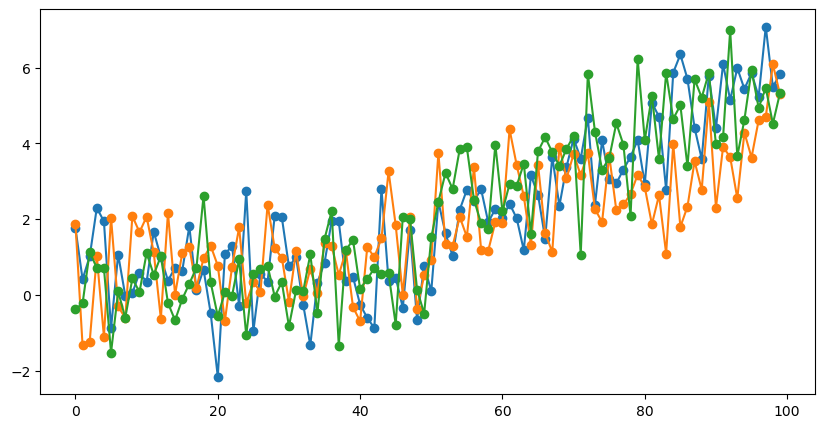

In [10]:
# plot each time series column against time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df[['value1', 'value2', 'value3']], marker='o', linestyle='-')
plt.show()

In [4]:
df = pd.read_csv('homework_3.1.csv', index_col=0)

# set the event time at time 50
t0 = df['time'].iloc[50]
after = (df['time'] >= t0).astype(int)
t_after = (df['time'] - t0) * after

# regress value1 on the event indicator and time
X = sm.add_constant(pd.DataFrame({"after": after, "t_after": t_after, "time": df['time']}))
results = sm.OLS(df['value1'], X).fit()
print(results.tvalues)

const      3.177909
after      2.362488
t_after    7.951259
time      -0.940435
dtype: float64


In [18]:
# regress value2 on the event indicator and time
X = sm.add_constant(pd.DataFrame({"after": after, "t_after": t_after, "time": df['time']}))
results = sm.OLS(df['value2'], X).fit()
print(results.tvalues)

const      1.708407
after      1.688480
t_after    2.566732
time       1.012986
dtype: float64


In [16]:
# regress value3 on the event indicator and time
X = sm.add_constant(pd.DataFrame({"after": after, "t_after": t_after, "time": df['time']}))
results = sm.OLS(df['value3'], X).fit()
print(results.tvalues)

const      0.369090
after      4.724217
t_after    3.857133
time       1.175817
dtype: float64


### differences in differences

In [22]:
# Scenario: a new grocery store opens up in town A but not town B.  Do the stores in town A reduce the price of a pound of apples
# because of this event?  Or do they reduce it for other reasons?

# First experiment: yes, it reduces

t = np.arange(1000) # time variable
t0 = 500 # time of the event
Y_A = 2 * (t < t0) + 1 * (t >= t0) + np.random.normal(0, 1, (1000,)) # apples in town A
Y_B = 1.5 + np.random.normal(0, 1, (1000,)) # apples in town B
Y = np.concatenate((Y_A, Y_B)) # create a combined dataset
group_A = np.concatenate((np.ones(1000), np.zeros(1000))) # group indicator for town A
After = np.tile(1 * (t >= t0), 2) # event indicator for both towns
Treated = group_A * After # interaction term for town A after the event
X = sm.add_constant(pd.DataFrame({"alpha_group": group_A, "alpha_time": After, "beta_1": Treated})) # design matrix
results = sm.OLS(Y, X).fit() #fit the model
results.params

const          1.513203
alpha_group    0.435776
alpha_time    -0.021533
beta_1        -0.913748
dtype: float64

In [27]:
X

,const,alpha_group,alpha_time,beta_1
0,1.0,1.0,0,0.0
1,1.0,1.0,0,0.0
2,1.0,1.0,0,0.0
3,1.0,1.0,0,0.0
4,1.0,1.0,0,0.0
...,...,...,...,...
1995,1.0,0.0,1,0.0
1996,1.0,0.0,1,0.0
1997,1.0,0.0,1,0.0
1998,1.0,0.0,1,0.0


In [20]:
def DID(num_times, before_const_A, after_const_A, before_const_B, after_const_B, sigma):
    t = np.arange(num_times)
    t0 = int(num_times / 2)
    Y_A = before_const_A * (t < t0) + after_const_A * (t >= t0) + np.random.normal(0, sigma, (num_times,))
    Y_B = before_const_B * (t < t0) + after_const_B * (t >= t0) + np.random.normal(0, sigma, (num_times,))
    Y = np.hstack((Y_A, Y_B))
    group_A = np.hstack((np.ones(num_times), np.zeros(num_times)))
    After = np.hstack((1 * (t >= t0), 1 * (t >= t0)))
    X = sm.add_constant(pd.DataFrame({"alpha_group": group_A, "alpha_time": After, "beta_1": group_A * After}))
    results = sm.OLS(Y, X).fit()
    return results

results = DID(num_times = 1000, before_const_A = 1.0, after_const_A = 2.0, before_const_B = 2.0, after_const_B = 3.0, sigma = 1)
results.params

const          1.984491
alpha_group   -1.028146
alpha_time     0.977622
beta_1         0.010558
dtype: float64

In [28]:
# 1. Read in each file
df_a = pd.read_csv('homework_3.2.a.csv', index_col=0)
df_b = pd.read_csv('homework_3.2.b.csv', index_col=0)

# 2. Harmonize column names so both frames use the same names
df_a = df_a.rename(columns={
    'group1':   'group',    # 0 = control town, 1 = treated town
    'time1':    'time',     # 0 = pre‐event, 1 = post‐event
    'outcome1': 'outcome'   # price of apples, say
})
df_b = df_b.rename(columns={
    'group2':   'group',
    'time2':    'time',
    'outcome2': 'outcome'
})

# 3. (Optional) If you want one big dataset to compare both scenarios at once, stack them:
df = pd.concat([df_a, df_b], ignore_index=True)

#    —or— if you want to run two separate DiDs (one per CSV), you can skip this and
#       repeat steps 4–6 on df_a and then on df_b.

# 4. Create your three key regressors:
df['alpha_group'] = df['group']              # group dummy
df['alpha_time']  = df['time']               # time dummy
df['beta_1']      = df['group'] * df['time'] # interaction = DiD

# 5. Build your design matrix (add a constant for the intercept)
X = sm.add_constant(df[['alpha_group','alpha_time','beta_1']])
Y = df['outcome']

# 6. Fit the OLS and inspect
results = sm.OLS(Y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1969.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        10:43:13   Log-Likelihood:                -2628.3
No. Observations:                2000   AIC:                             5265.
Df Residuals:                    1996   BIC:                             5287.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0381      0.040      0.948      

In [29]:
import pandas as pd
import statsmodels.api as sm

def run_did(csv_path):
    # 1) Load and rename columns to a common schema
    df = pd.read_csv(csv_path, index_col=0)
    df = df.rename(columns={
        df.columns[0]: 'group',    # treatment vs. control
        df.columns[1]: 'time',     # before (0) vs. after (1)
        df.columns[2]: 'outcome'   # the outcome variable
    })

    # 2) Build the DiD regressors
    df['alpha_group'] = df['group']           # group dummy
    df['alpha_time']  = df['time']            # time dummy
    df['beta_1']      = df['group'] * df['time']  # interaction term

    # 3) Fit the OLS DiD model
    X = sm.add_constant(df[['alpha_group', 'alpha_time', 'beta_1']])
    y = df['outcome']
    results = sm.OLS(y, X).fit()

    # 4) Print just the coefficient table
    print(f"\n=== Results for {csv_path} ===")
    print(results.summary().tables[1])  # coefficient, std err, t, p-value

# Run on both “before” and “after” files:
for path in ['homework_3.2.a.csv', 'homework_3.2.b.csv']:
    run_did(path)


=== Results for homework_3.2.a.csv ===
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0258      0.031     -0.829      0.408      -0.087       0.035
alpha_group     1.9863      0.044     44.928      0.000       1.900       2.073
alpha_time      1.4272      0.044     32.315      0.000       1.341       1.514
beta_1          0.6858      0.063     10.970      0.000       0.563       0.809

=== Results for homework_3.2.b.csv ===
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1021      0.073      1.392      0.164      -0.042       0.246
alpha_group     1.8477      0.104     17.770      0.000       1.644       2.052
alpha_time      1.2655      0.104     12.183      0.000       1.062       1.469
beta_1          1.3499      0.147      9

In [30]:
df_a

,group,time,outcome
0,0,0,0.882026
1,0,1,1.600079
2,0,0,0.489369
3,0,1,2.520447
4,0,0,0.933779
...,...,...,...
995,1,1,4.306435
996,1,0,1.900801
997,1,1,4.147096
998,1,0,1.426195
